In [65]:
from src.utils import poses_from_vicon, set_axes_equal, compute_transformation_matrix, apply_transformation, compute_ate
import matplotlib.pyplot as plt
import h5py
import numpy as np
np.set_printoptions(precision=3, suppress=True)
%matplotlib widget

from scipy.signal import resample_poly
from scipy.spatial.transform import Rotation as R

import cv2
import mediapy
from PIL import Image, ImageDraw, ImageFont
from scipy.interpolate import interp1d



### Data Reading & Synchronization

In [2]:
def receive_data(path, trial):
    # Read device poses
    f = h5py.File(f"{path}/{trial}.h5",'r')
    poses = np.array(f['pose_values'])
    color_images = np.array(f['color_images'])
    
    # Read Vicon poses
    vicon_poses = poses_from_vicon(f"{path}/{trial}.csv")
    up = 3  
    down = 10 
    vicon_poses_downsampled = resample_poly(vicon_poses, up, down)
    
    # Loop through all possible starting points and find the one with the lowest ATE
    frame_diff = len(vicon_poses_downsampled)-len(poses)    
    best_idx = 0
    best_ate = 1e9
    for idx in range(frame_diff):
        vicon_poses_cropped = vicon_poses_downsampled[idx:idx+len(poses)]
        R_optimal, t_optimal = compute_transformation_matrix(poses, vicon_poses_cropped)
        aligned_estimated_poses = apply_transformation(poses, R_optimal, t_optimal) 
        ate = compute_ate(aligned_estimated_poses, vicon_poses_cropped)
    
        if ate < best_ate:
            best_ate = ate
            best_idx = idx

    vicon_poses_final = vicon_poses_downsampled[best_idx:best_idx+len(poses)]
    
    R_optimal, t_optimal = compute_transformation_matrix(poses, vicon_poses_final)
    aligned_poses = apply_transformation(poses, R_optimal, t_optimal) 
    
    print(f"{trial} - best ATE {best_ate:.4f} at index {best_idx}")
    
    return aligned_poses, vicon_poses_final, color_images 

In [4]:
poses1, vicon_poses1, video1 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial1")
poses2, vicon_poses2, video2 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial2")
poses3, vicon_poses3, video3 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial3")
poses4, vicon_poses4, video4 = receive_data(path="/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing", trial="trial4")

trial1 - best ATE 0.0333 at index 24
trial2 - best ATE 0.0255 at index 19
trial3 - best ATE 0.0265 at index 19
trial4 - best ATE 0.0311 at index 13


### Manual Seperation of Episodes

In [29]:
def annotate_and_show(video):
    annotated_frames = []
    for idx, frame in enumerate(video):    
        img = Image.fromarray(frame)
        draw = ImageDraw.Draw(img)
        draw.text((20, 20), str(idx), fill=(255, 255, 255))
        annotated_frames.append(np.array(img))
    
    mediapy.show_video(annotated_frames, fps=30)
    

In [55]:
# annotate_and_show(video4)

In [50]:
episode1_indices = range(0,155)
episode2_indices = range(260,460)
episode3_indices = range(550,719)

episode4_indices = range(0,179)
episode5_indices = range(280,406)
episode6_indices = range(510,683)

episode7_indices = range(0,233)
episode8_indices = range(325,535)
episode9_indices = range(700,928)

episode10_indices = range(25,220)
episode11_indices = range(330,535)
episode12_indices = range(640,840)

In [72]:
cleaned_poses = [
    poses1[episode1_indices],
    poses1[episode2_indices],
    poses1[episode3_indices],
    poses2[episode4_indices],
    poses2[episode5_indices],
    poses2[episode6_indices],
    poses3[episode7_indices],
    poses3[episode8_indices],
    poses3[episode9_indices],
    poses4[episode10_indices],
    poses4[episode11_indices],
    poses4[episode12_indices]
]

cleaned_vicon_poses = [
    vicon_poses1[episode1_indices],
    vicon_poses1[episode2_indices],
    vicon_poses1[episode3_indices],
    vicon_poses2[episode4_indices],
    vicon_poses2[episode5_indices],
    vicon_poses2[episode6_indices],
    vicon_poses3[episode7_indices],
    vicon_poses3[episode8_indices],
    vicon_poses3[episode9_indices],
    vicon_poses4[episode10_indices],
    vicon_poses4[episode11_indices],
    vicon_poses4[episode12_indices]
]

### Interpolate to [0,100] % Episode Completion Axis

In [94]:
def interpolate_to_percentage(data, num_points=100):
    current_indices = np.linspace(0, len(data)-1, num=len(data))
    target_indices = np.linspace(0, len(data)-1, num=num_points)
    interpolation_function = interp1d(current_indices, data, axis=0)
    return interpolation_function(target_indices)

abs_errors = []  
abs_errors_rescaled = []
abs_pos_errors = []

for i in range(len(cleaned_poses)):
    abs_error = np.abs(cleaned_poses[i] - cleaned_vicon_poses[i])
    abs_error_interpolated = interpolate_to_percentage(abs_error)
    
    abs_errors.append(abs_error)
    abs_errors_rescaled.append(abs_error_interpolated)
    abs_pos_errors.append(abs_error_interpolated[:,:3,3]*1000)

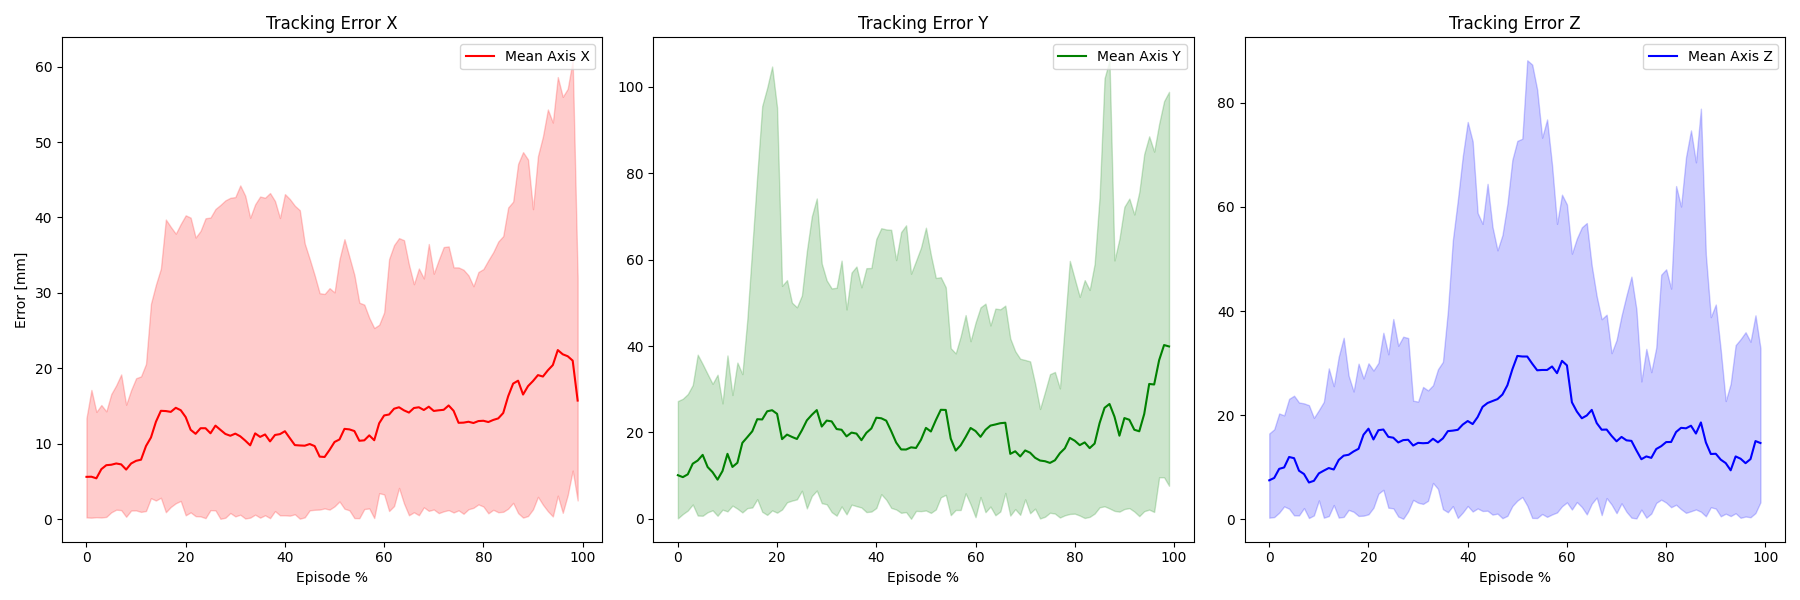

In [105]:
mean_errors = np.mean(abs_pos_errors, axis=0)
min_errors = np.min(abs_pos_errors, axis=0)
max_errors = np.max(abs_pos_errors, axis=0)

axis_labels = ['X', 'Y', 'Z']
colors = ['r', 'g', 'b']

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
for i in range(3):
    axs[i].plot(mean_errors[:,i], label=f'Mean Axis {axis_labels[i]}', color=colors[i])
    axs[i].fill_between(range(100), min_errors[:,i], max_errors[:,i], color=colors[i], alpha=0.2)
    axs[i].set_xlabel('Episode %')
    axs[i].set_title(f'Tracking Error {axis_labels[i]}')
    axs[i].legend()
axs[0].set_ylabel('Error [mm]')
plt.tight_layout() 
plt.show()

### Pose Alignment & Error Calculation

In [113]:
# Compute RMSE for translation components
for i in range(len(cleaned_poses)):
    print(f'#####Episode{i+1}#####')
    rmse_translation = np.sqrt(np.mean((cleaned_poses[i][:, :3, 3] - cleaned_vicon_poses[i][:, :3, 3])**2))
    print(f'RMSE: {rmse_translation*1000:.2f}')

    ate = compute_ate(cleaned_poses[i], cleaned_vicon_poses[i])
    print(f'ATE:  {ate*1000:.2f}')

# Optionally, compute RMSE for rotation components
# Convert rotation matrices to quaternions for easier comparison
# def rotation_matrix_to_quaternion(R):
#     return R.from_matrix(R).as_quat()

# estimated_quaternions = np.array([rotation_matrix_to_quaternion(R) for R in aligned_estimated_poses[:, :3, :3]])
# ground_truth_quaternions = np.array([rotation_matrix_to_quaternion(R) for R in vicon_poses_downsampled[:, :3, :3]])

# rmse_rotation = np.sqrt(np.mean((estimated_quaternions - ground_truth_quaternions)**2))
# print(f'RMSE (Rotation): {rmse_rotation}')

#####Episode1#####
RMSE: 20.16
ATE:  28.26
#####Episode2#####
RMSE: 24.64
ATE:  38.55
#####Episode3#####
RMSE: 28.79
ATE:  42.75
#####Episode4#####
RMSE: 15.26
ATE:  23.52
#####Episode5#####
RMSE: 14.68
ATE:  23.22
#####Episode6#####
RMSE: 24.73
ATE:  38.36
#####Episode7#####
RMSE: 22.57
ATE:  34.24
#####Episode8#####
RMSE: 15.21
ATE:  21.94
#####Episode9#####
RMSE: 21.92
ATE:  35.00
#####Episode10#####
RMSE: 20.99
ATE:  30.32
#####Episode11#####
RMSE: 17.37
ATE:  27.44
#####Episode12#####
RMSE: 33.55
ATE:  50.35


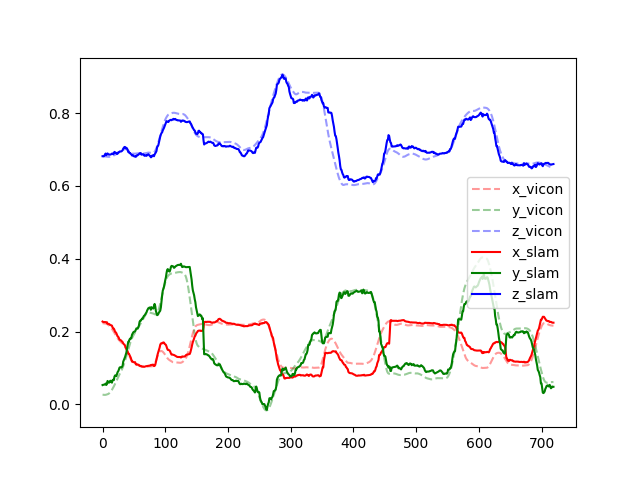

In [ ]:
fig = plt.figure()
plt.plot(vicon_poses_downsampled[:,0,3], label="x_vicon", alpha=0.4, linestyle="dashed", color="r")
plt.plot(vicon_poses_downsampled[:,1,3], label="y_vicon", alpha=0.4, linestyle="dashed", color="g")
plt.plot(vicon_poses_downsampled[:,2,3], label="z_vicon", alpha=0.4, linestyle="dashed", color="b")
plt.plot(aligned_estimated_poses[:,0,3], label="x_slam", color="r")
plt.plot(aligned_estimated_poses[:,1,3], label="y_slam", color="g")
plt.plot(aligned_estimated_poses[:,2,3], label="z_slam", color="b")
plt.legend()
plt.show()

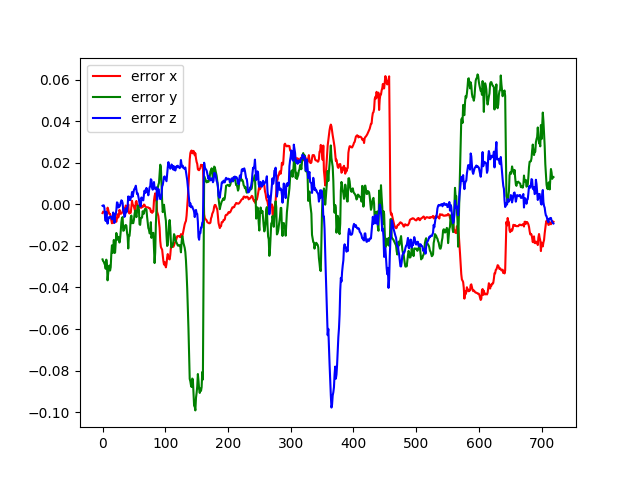

In [ ]:
fig = plt.figure()
plt.plot(vicon_poses_downsampled[:,0,3]-aligned_estimated_poses[:,0,3], label="error x", color="r")
plt.plot(vicon_poses_downsampled[:,1,3]-aligned_estimated_poses[:,1,3], label="error y", color="g")
plt.plot(vicon_poses_downsampled[:,2,3]-aligned_estimated_poses[:,2,3], label="error z", color="b")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


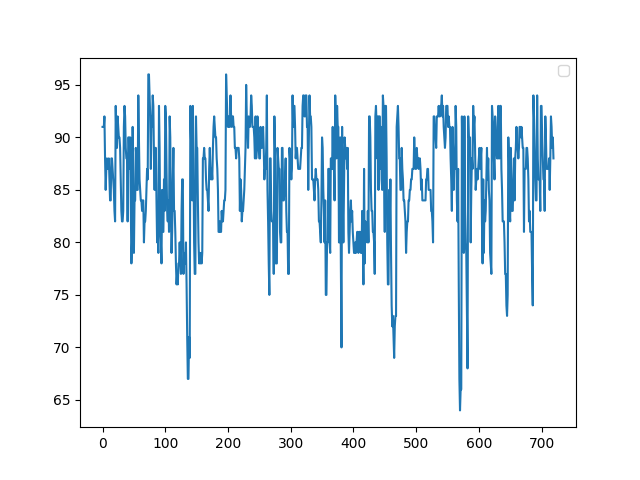

In [ ]:
fig = plt.figure()
plt.plot(pose_confidences)
plt.legend()
plt.show()

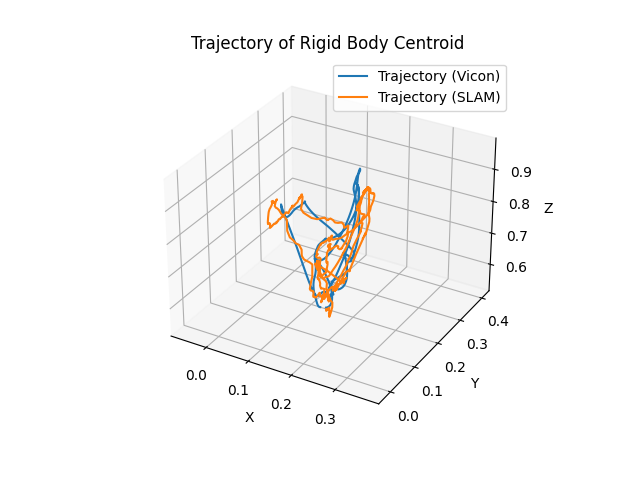

In [ ]:
# Visualize the trajectory of the centroid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(vicon_poses_downsampled[:,0,3],vicon_poses_downsampled[:,1,3],vicon_poses_downsampled[:,2,3], label='Trajectory (Vicon)')
ax.plot(aligned_estimated_poses[:,0,3],aligned_estimated_poses[:,1,3],aligned_estimated_poses[:,2,3], label='Trajectory (SLAM)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)
ax.set_title('Trajectory of Rigid Body Centroid')
plt.legend()
plt.show()

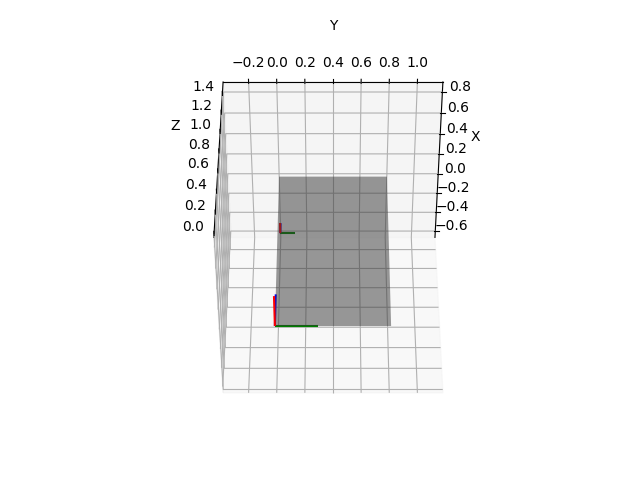

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_box_aspect([1.0, 1.0, 1.0])


t = vicon_poses[0,:3, 3]
R = vicon_poses[0,:3, :3]
ax.quiver(t[0], t[1], t[2], R[0, 0], R[1, 0], R[2, 0], length=0.1, color='r', arrow_length_ratio=0)
ax.quiver(t[0], t[1], t[2], R[0, 1], R[1, 1], R[2, 1], length=0.1, color='g', arrow_length_ratio=0)
ax.quiver(t[0], t[1], t[2], R[0, 2], R[1, 2], R[2, 2], length=0.1, color='b', arrow_length_ratio=0)
ax.quiver(0,0,0, 1, 0, 0, length=0.3, color='r', arrow_length_ratio=0)
ax.quiver(0,0,0, 0,1,0, length=0.3, color='g', arrow_length_ratio=0)
ax.quiver(0,0,0, 0,0,1, length=0.3, color='b', arrow_length_ratio=0)

# Define the range for y and z
y = np.linspace(0, 0.8, 100)
z = np.linspace(0, 1.5, 100)
# Create a grid for y and z
Y, Z = np.meshgrid(y, z)
# Define x as a constant (e.g., x = 5)
X = np.full_like(Y, 0)

# Plot the plane
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='grey')

    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
    
ax.grid(True)
ax.view_init(elev=-45, azim=0, roll=0)

set_axes_equal(ax)
plt.show()